In [1]:
import math, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Simple 1-D regression target: y = sin(x) + noise
def make_dataset(n=200, noise_std=0.1, seed=0):
    rng = np.random.default_rng(seed)
    x = rng.uniform(-3.0, 3.0, size=(n, 1)).astype(np.float32)
    y = np.sin(x) + rng.normal(0.0, noise_std, size=(n, 1)).astype(np.float32)
    return torch.tensor(x), torch.tensor(y)

x_train, y_train = make_dataset()
print(x_train.shape, y_train.shape)

torch.Size([200, 1]) torch.Size([200, 1])


In [3]:
class MCDropoutNet(nn.Module):
    def __init__(self, hidden=32, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.ReLU(),
            nn.Dropout(p),          # <-- keep at test time!
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MCDropoutNet()
print(sum(p.numel() for p in model.parameters()), "parameters")

1153 parameters


In [ ]:
epochs, lr = 50000, 1e-4
opt = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

for epoch in range(1, epochs + 1):
    opt.zero_grad()
    pred = model(x_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    opt.step()
    
    if epoch % 2000 == 0:
        print(f"epoch {epoch:4d}: train-MSE {loss.item():.4f}")

epoch 2000: train-MSE 0.0462
epoch 4000: train-MSE 0.0305
epoch 6000: train-MSE 0.0233
epoch 8000: train-MSE 0.0231
epoch 10000: train-MSE 0.0181
epoch 12000: train-MSE 0.0188
epoch 14000: train-MSE 0.0159
epoch 16000: train-MSE 0.0188
epoch 18000: train-MSE 0.0187
epoch 20000: train-MSE 0.0165
epoch 22000: train-MSE 0.0159
epoch 24000: train-MSE 0.0137
epoch 26000: train-MSE 0.0157
epoch 28000: train-MSE 0.0141
epoch 30000: train-MSE 0.0160
epoch 32000: train-MSE 0.0157
epoch 34000: train-MSE 0.0151
epoch 36000: train-MSE 0.0168
epoch 38000: train-MSE 0.0145
epoch 40000: train-MSE 0.0124
epoch 42000: train-MSE 0.0157
epoch 44000: train-MSE 0.0151
epoch 46000: train-MSE 0.0157
epoch 48000: train-MSE 0.0147
epoch 50000: train-MSE 0.0126


In [5]:
@torch.no_grad()
def mc_predict(x, T=100):
    """
    Returns predictive mean and variance for input tensor x.
    Dropout stays *on* by calling model.train().
    """
    model.train()                               # crucial: keep dropout active
    preds = torch.stack([model(x) for _ in range(T)], dim=0)  # [T, N, 1]
    mean = preds.mean(dim=0).squeeze(1)         # [N]
    var  = preds.var (dim=0).squeeze(1)         # [N]
    return mean, var

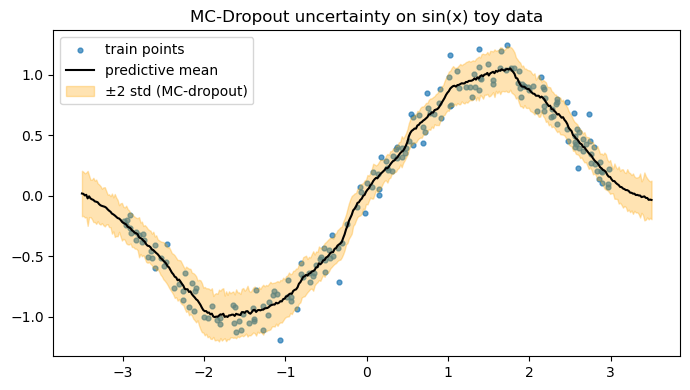

In [6]:
# Create a dense grid for plotting
x_plot = torch.linspace(-3.5, 3.5, steps=400).unsqueeze(1)
mean, var = mc_predict(x_plot, T=200)
std = var.sqrt()

plt.figure(figsize=(7,4))
plt.scatter(x_train, y_train, s=12, alpha=0.7, label="train points")
plt.plot(x_plot, mean, color="black", lw=1.5, label="predictive mean")
plt.fill_between(
    x_plot.squeeze(),                         # x axis
    (mean - 2*std).numpy(),                  # lower band
    (mean + 2*std).numpy(),                  # upper band
    color="orange", alpha=0.3, label="±2 std (MC-dropout)"
)
plt.title("MC-Dropout uncertainty on sin(x) toy data")
plt.legend(); plt.tight_layout(); plt.show()